In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_roi_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 304)
(631390, 1)
validation
(74368, 304)
(74368, 1)
test
(85358, 304)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1001473 (3.82 MB)


Trainable params: 1001473 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:10 - loss: 0.1523 - STD: 9.5670e-05 - MAE: 0.3776

 6/64 [=>............................] - ETA: 0s - loss: 0.0421 - STD: 8.6232e-05 - MAE: 0.1555  

11/64 [====>.........................] - ETA: 0s - loss: 0.0362 - STD: 5.2309e-05 - MAE: 0.1480

17/64 [======>.......................] - ETA: 0s - loss: 0.0327 - STD: 3.5852e-05 - MAE: 0.1417

22/64 [=========>....................] - ETA: 0s - loss: 0.0291 - STD: 3.1238e-05 - MAE: 0.1311

28/64 [============>.................] - ETA: 0s - loss: 0.0251 - STD: 2.8517e-05 - MAE: 0.1205

33/64 [==============>...............] - ETA: 0s - loss: 0.0232 - STD: 2.6328e-05 - MAE: 0.1166

38/64 [================>.............] - ETA: 0s - loss: 0.0215 - STD: 2.4356e-05 - MAE: 0.1118

44/64 [===================>..........] - ETA: 0s - loss: 0.0200 - STD: 2.2396e-05 - MAE: 0.1070

47/64 [=====================>........] - ETA: 0s - loss: 0.0196 - STD: 2.1612e-05 - MAE: 0.1050

53/64 [=======================>......] - ETA: 0s - loss: 0.0185 - STD: 2.0399e-05 - MAE: 0.1020

59/64 [==========================>...] - ETA: 0s - loss: 0.0176 - STD: 1.9622e-05 - MAE: 0.0998

64/64 [==============================] - 3s 27ms/step - loss: 0.0170 - STD: 1.9107e-05 - MAE: 0.0981 - val_loss: 0.0094 - val_STD: 1.0469e-05 - val_MAE: 0.0757


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0099 - STD: 1.2973e-05 - MAE: 0.0768

 6/64 [=>............................] - ETA: 0s - loss: 0.0100 - STD: 1.2670e-05 - MAE: 0.0770

12/64 [====>.........................] - ETA: 0s - loss: 0.0100 - STD: 1.3688e-05 - MAE: 0.0775

18/64 [=======>......................] - ETA: 0s - loss: 0.0100 - STD: 1.4138e-05 - MAE: 0.0780

23/64 [=========>....................] - ETA: 0s - loss: 0.0100 - STD: 1.4691e-05 - MAE: 0.0780

28/64 [============>.................] - ETA: 0s - loss: 0.0100 - STD: 1.5333e-05 - MAE: 0.0779

34/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 1.5957e-05 - MAE: 0.0778

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 1.6533e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 1.7090e-05 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.7678e-05 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.8200e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.8898e-05 - MAE: 0.0778

64/64 [==============================] - 1s 11ms/step - loss: 0.0099 - STD: 1.9120e-05 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 2.1523e-05 - val_MAE: 0.0764


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0099 - STD: 2.6905e-05 - MAE: 0.0777

 6/64 [=>............................] - ETA: 0s - loss: 0.0099 - STD: 2.7129e-05 - MAE: 0.0778

12/64 [====>.........................] - ETA: 0s - loss: 0.0099 - STD: 2.8314e-05 - MAE: 0.0777

18/64 [=======>......................] - ETA: 0s - loss: 0.0099 - STD: 2.9214e-05 - MAE: 0.0778

24/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 3.0506e-05 - MAE: 0.0779

30/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 3.1629e-05 - MAE: 0.0781

35/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 3.2605e-05 - MAE: 0.0781

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 3.3540e-05 - MAE: 0.0781

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 3.4810e-05 - MAE: 0.0780

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.6287e-05 - MAE: 0.0780

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.7684e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.9055e-05 - MAE: 0.0779

64/64 [==============================] - 1s 11ms/step - loss: 0.0099 - STD: 3.9323e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 4.5927e-05 - val_MAE: 0.0765


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0097 - STD: 5.6788e-05 - MAE: 0.0778

 7/64 [==>...........................] - ETA: 0s - loss: 0.0099 - STD: 5.8537e-05 - MAE: 0.0776

13/64 [=====>........................] - ETA: 0s - loss: 0.0099 - STD: 6.0076e-05 - MAE: 0.0777

18/64 [=======>......................] - ETA: 0s - loss: 0.0099 - STD: 6.1482e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 6.3336e-05 - MAE: 0.0779

30/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 6.5203e-05 - MAE: 0.0780

35/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 6.7005e-05 - MAE: 0.0779

41/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 6.9377e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 7.1455e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 7.4148e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 7.6575e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 7.9217e-05 - MAE: 0.0778

64/64 [==============================] - 1s 11ms/step - loss: 0.0099 - STD: 8.0337e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 9.6197e-05 - val_MAE: 0.0766


Epoch 5/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0101 - STD: 1.1515e-04 - MAE: 0.0786

 7/64 [==>...........................] - ETA: 0s - loss: 0.0099 - STD: 1.2116e-04 - MAE: 0.0780

13/64 [=====>........................] - ETA: 0s - loss: 0.0099 - STD: 1.2676e-04 - MAE: 0.0778

19/64 [=======>......................] - ETA: 0s - loss: 0.0099 - STD: 1.3261e-04 - MAE: 0.0780

25/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 1.3933e-04 - MAE: 0.0780

30/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 1.4532e-04 - MAE: 0.0780

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 1.5306e-04 - MAE: 0.0779

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 1.6156e-04 - MAE: 0.0779

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.7079e-04 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.8061e-04 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.8970e-04 - MAE: 0.0778

64/64 [==============================] - 1s 11ms/step - loss: 0.0099 - STD: 1.9963e-04 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 2.7738e-04 - val_MAE: 0.0762


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0101 - STD: 3.4017e-04 - MAE: 0.0782

 7/64 [==>...........................] - ETA: 0s - loss: 0.0100 - STD: 3.5916e-04 - MAE: 0.0783

12/64 [====>.........................] - ETA: 0s - loss: 0.0099 - STD: 3.7893e-04 - MAE: 0.0781

17/64 [======>.......................] - ETA: 0s - loss: 0.0099 - STD: 4.0152e-04 - MAE: 0.0780

23/64 [=========>....................] - ETA: 0s - loss: 0.0099 - STD: 4.3171e-04 - MAE: 0.0780

29/64 [============>.................] - ETA: 0s - loss: 0.0099 - STD: 4.6729e-04 - MAE: 0.0779

35/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 5.0780e-04 - MAE: 0.0778

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 5.4715e-04 - MAE: 0.0778

45/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 5.9295e-04 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 6.5796e-04 - MAE: 0.0777

57/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 7.3618e-04 - MAE: 0.0777

63/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 8.3213e-04 - MAE: 0.0776

64/64 [==============================] - 1s 11ms/step - loss: 0.0098 - STD: 8.5021e-04 - MAE: 0.0776 - val_loss: 0.0092 - val_STD: 0.0017 - val_MAE: 0.0755


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0095 - STD: 0.0021 - MAE: 0.0762

 6/64 [=>............................] - ETA: 0s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0770

12/64 [====>.........................] - ETA: 0s - loss: 0.0096 - STD: 0.0026 - MAE: 0.0770

17/64 [======>.......................] - ETA: 0s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0769

22/64 [=========>....................] - ETA: 0s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0768

27/64 [===========>..................] - ETA: 0s - loss: 0.0095 - STD: 0.0039 - MAE: 0.0766

33/64 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 0.0046 - MAE: 0.0762

39/64 [=================>............] - ETA: 0s - loss: 0.0093 - STD: 0.0056 - MAE: 0.0759

45/64 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 0.0068 - MAE: 0.0755

51/64 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0082 - MAE: 0.0750

56/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0097 - MAE: 0.0745

61/64 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0114 - MAE: 0.0740

64/64 [==============================] - 1s 11ms/step - loss: 0.0088 - STD: 0.0125 - MAE: 0.0737 - val_loss: 0.0063 - val_STD: 0.0313 - val_MAE: 0.0635


Epoch 8/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0072 - STD: 0.0375 - MAE: 0.0658

 7/64 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0414 - MAE: 0.0651

13/64 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0446 - MAE: 0.0642

19/64 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0471 - MAE: 0.0638

24/64 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0484 - MAE: 0.0635

30/64 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0492 - MAE: 0.0632

36/64 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0630

42/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0506 - MAE: 0.0628

47/64 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0511 - MAE: 0.0628

52/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0514 - MAE: 0.0627

58/64 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0518 - MAE: 0.0626

64/64 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0522 - MAE: 0.0624

64/64 [==============================] - 1s 11ms/step - loss: 0.0066 - STD: 0.0522 - MAE: 0.0624 - val_loss: 0.0056 - val_STD: 0.0467 - val_MAE: 0.0585


Epoch 9/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0551 - MAE: 0.0611

 6/64 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0554 - MAE: 0.0609

12/64 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0557 - MAE: 0.0610

18/64 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0559 - MAE: 0.0608

24/64 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0561 - MAE: 0.0609

29/64 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0562 - MAE: 0.0610

34/64 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0562 - MAE: 0.0609

39/64 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0564 - MAE: 0.0609

45/64 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0565 - MAE: 0.0609

50/64 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0566 - MAE: 0.0608

55/64 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0608

60/64 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0569 - MAE: 0.0608

64/64 [==============================] - 1s 11ms/step - loss: 0.0064 - STD: 0.0569 - MAE: 0.0608 - val_loss: 0.0055 - val_STD: 0.0499 - val_MAE: 0.0584


Epoch 10/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0580 - MAE: 0.0608

 6/64 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0599

11/64 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0601

16/64 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0601

21/64 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0602

26/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0602

31/64 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0601

36/64 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0601

41/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0601

46/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0601

52/64 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0600

58/64 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0600

64/64 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0600

64/64 [==============================] - 1s 12ms/step - loss: 0.0063 - STD: 0.0587 - MAE: 0.0600 - val_loss: 0.0054 - val_STD: 0.0502 - val_MAE: 0.0570


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0593 - MAE: 0.0587

 6/64 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0590 - MAE: 0.0597

11/64 [====>.........................] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0595

16/64 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0597

21/64 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0596

27/64 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0595

33/64 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0596

38/64 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0595

43/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0595

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0595

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0595

60/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0595

64/64 [==============================] - 1s 11ms/step - loss: 0.0061 - STD: 0.0598 - MAE: 0.0594 - val_loss: 0.0053 - val_STD: 0.0523 - val_MAE: 0.0569


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0587

 6/64 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0591

12/64 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0599 - MAE: 0.0593

18/64 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0600 - MAE: 0.0594

24/64 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0593

30/64 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0600 - MAE: 0.0593

35/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0592

40/64 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0603 - MAE: 0.0591

46/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0591

52/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0591

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0590

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0590

64/64 [==============================] - 1s 11ms/step - loss: 0.0061 - STD: 0.0606 - MAE: 0.0590 - val_loss: 0.0052 - val_STD: 0.0523 - val_MAE: 0.0563


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0587

 7/64 [==>...........................] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0587

12/64 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0587

17/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0587

22/64 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0585

28/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0585

33/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0585

38/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0584

44/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0584

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0584

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0584

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0583

64/64 [==============================] - 1s 11ms/step - loss: 0.0059 - STD: 0.0618 - MAE: 0.0583 - val_loss: 0.0052 - val_STD: 0.0534 - val_MAE: 0.0564


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0615 - MAE: 0.0577

 7/64 [==>...........................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0582

12/64 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0580

17/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0619 - MAE: 0.0580

22/64 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0581

27/64 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0619 - MAE: 0.0580

32/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0580

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0579

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0579

48/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0622 - MAE: 0.0578

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0579

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0579

64/64 [==============================] - 1s 11ms/step - loss: 0.0058 - STD: 0.0624 - MAE: 0.0579 - val_loss: 0.0052 - val_STD: 0.0545 - val_MAE: 0.0562


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0573

 6/64 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0618 - MAE: 0.0572

11/64 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0627 - MAE: 0.0575

16/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0625 - MAE: 0.0576

21/64 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0576

27/64 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0575

33/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0576

38/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0576

44/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0577

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0578

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0578

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0577

64/64 [==============================] - 1s 12ms/step - loss: 0.0058 - STD: 0.0626 - MAE: 0.0577 - val_loss: 0.0053 - val_STD: 0.0573 - val_MAE: 0.0576


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0653 - MAE: 0.0583

 6/64 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0572

11/64 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0571

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0570

22/64 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0570

28/64 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0569

33/64 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0568

39/64 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0569

44/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0569

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0569

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0569

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0569

64/64 [==============================] - 1s 11ms/step - loss: 0.0057 - STD: 0.0638 - MAE: 0.0569 - val_loss: 0.0050 - val_STD: 0.0549 - val_MAE: 0.0547


Epoch 17/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0617 - MAE: 0.0563

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0568

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0569

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0568

22/64 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0568

27/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0569

32/64 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0567

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0568

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0568

47/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0568

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0567

57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0566

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0566

64/64 [==============================] - 1s 11ms/step - loss: 0.0056 - STD: 0.0641 - MAE: 0.0566 - val_loss: 0.0053 - val_STD: 0.0600 - val_MAE: 0.0577


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0679 - MAE: 0.0571

 7/64 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0562

12/64 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0645 - MAE: 0.0561

18/64 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0563

24/64 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0563

30/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0563

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0564

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0564

47/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0565

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0564

58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0564

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0564

64/64 [==============================] - 1s 11ms/step - loss: 0.0056 - STD: 0.0647 - MAE: 0.0564 - val_loss: 0.0050 - val_STD: 0.0569 - val_MAE: 0.0549


Epoch 19/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0558

 6/64 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0561

11/64 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0560

16/64 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0559

22/64 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0562

27/64 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0562

32/64 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0562

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0562

42/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0561

47/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0561

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0561

57/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0561

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0561

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0651 - MAE: 0.0561 - val_loss: 0.0065 - val_STD: 0.0642 - val_MAE: 0.0650


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0729 - MAE: 0.0611

 7/64 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0572

12/64 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0569

18/64 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0568

24/64 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0566

30/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0565

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0564

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0562

48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0562

53/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0562

59/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0561

64/64 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0651 - MAE: 0.0561 - val_loss: 0.0049 - val_STD: 0.0556 - val_MAE: 0.0535


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0617 - MAE: 0.0560

 6/64 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0558

11/64 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0558

16/64 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0556

21/64 [========>.....................] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

26/64 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0557

32/64 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0556

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0556

53/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0556

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0556

63/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

64/64 [==============================] - 1s 12ms/step - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556 - val_loss: 0.0050 - val_STD: 0.0594 - val_MAE: 0.0550


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0551

 6/64 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0552

11/64 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0552

16/64 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0553

21/64 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0553

26/64 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0553

31/64 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0554

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0554

47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0554

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

64/64 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554 - val_loss: 0.0050 - val_STD: 0.0587 - val_MAE: 0.0544


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0052 - STD: 0.0641 - MAE: 0.0542

 6/64 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0552

11/64 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0551

16/64 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

21/64 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

27/64 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

32/64 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0552

47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0552

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

64/64 [==============================] - 1s 12ms/step - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553 - val_loss: 0.0054 - val_STD: 0.0630 - val_MAE: 0.0577


Epoch 24/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0678 - MAE: 0.0554

 6/64 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0548

11/64 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

16/64 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0550

20/64 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0555

30/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0556

35/64 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0558

39/64 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0558

44/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0558

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0559

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0559

59/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0558

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0557

64/64 [==============================] - 1s 12ms/step - loss: 0.0055 - STD: 0.0656 - MAE: 0.0557 - val_loss: 0.0052 - val_STD: 0.0603 - val_MAE: 0.0561


Epoch 25/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0657 - MAE: 0.0548

 6/64 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0553

11/64 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0550

16/64 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0550

21/64 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

26/64 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0550

31/64 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0550

36/64 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0550

41/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0550

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

64/64 [==============================] - 1s 12ms/step - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551 - val_loss: 0.0054 - val_STD: 0.0625 - val_MAE: 0.0574


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0687 - MAE: 0.0556

 6/64 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

11/64 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

16/64 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0552

21/64 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

27/64 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0552

32/64 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0552

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0552

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0552

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0551

64/64 [==============================] - 1s 12ms/step - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551 - val_loss: 0.0055 - val_STD: 0.0635 - val_MAE: 0.0583


Epoch 27/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0686 - MAE: 0.0558

 6/64 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0550

11/64 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0550

16/64 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0550

22/64 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0550

27/64 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0550

32/64 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0549

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0549

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0549

47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0549

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0549

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0549

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0549

64/64 [==============================] - 1s 12ms/step - loss: 0.0053 - STD: 0.0671 - MAE: 0.0548 - val_loss: 0.0052 - val_STD: 0.0615 - val_MAE: 0.0560


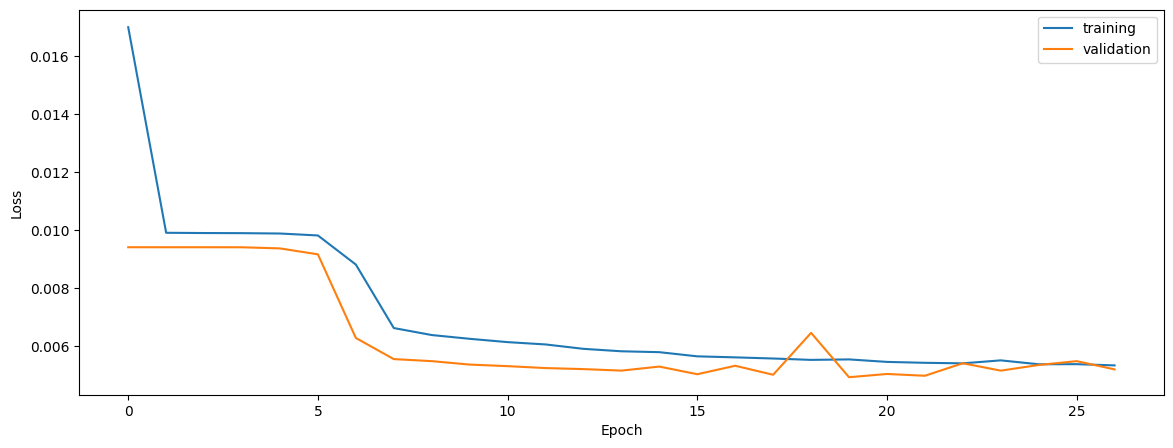

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


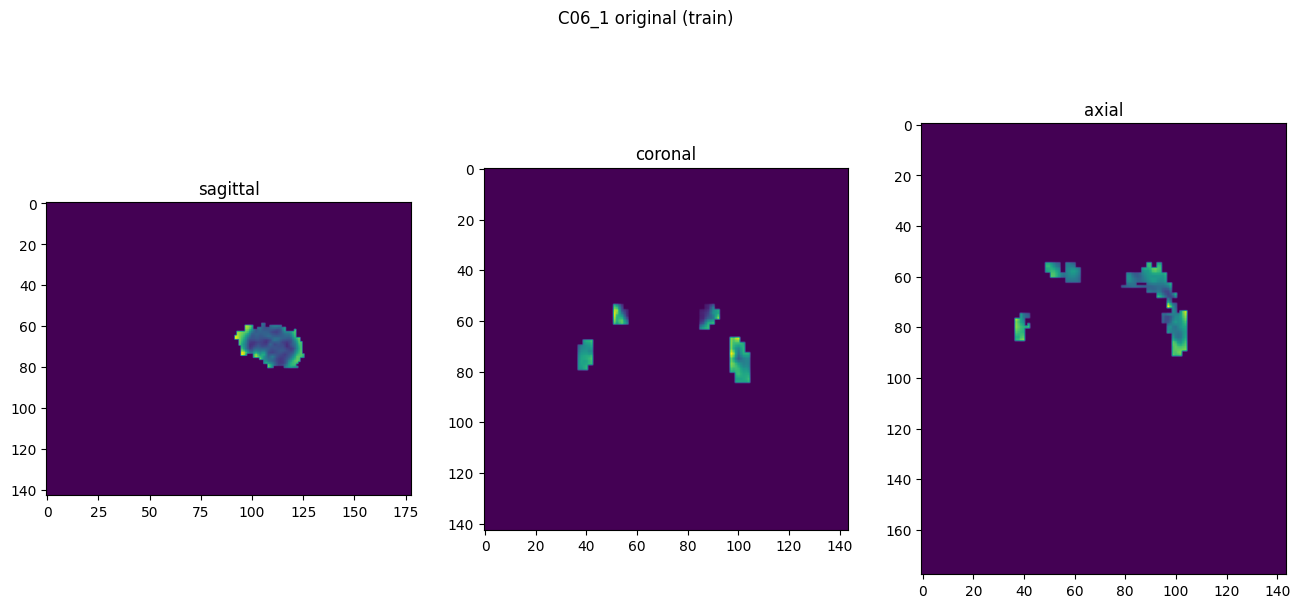

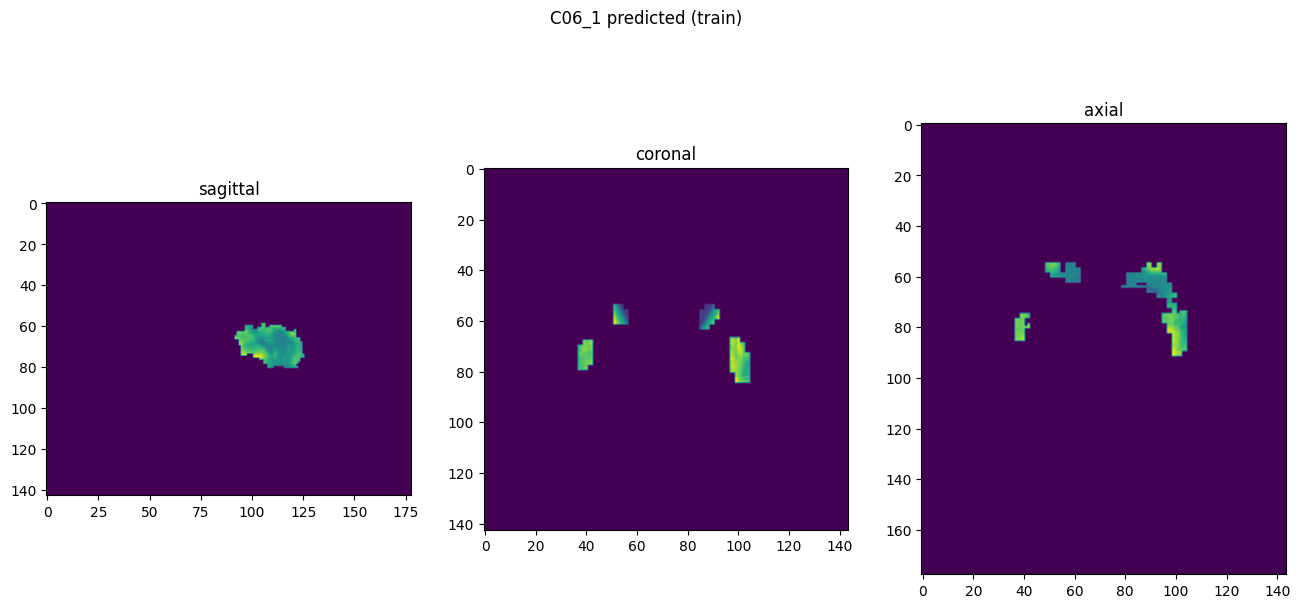

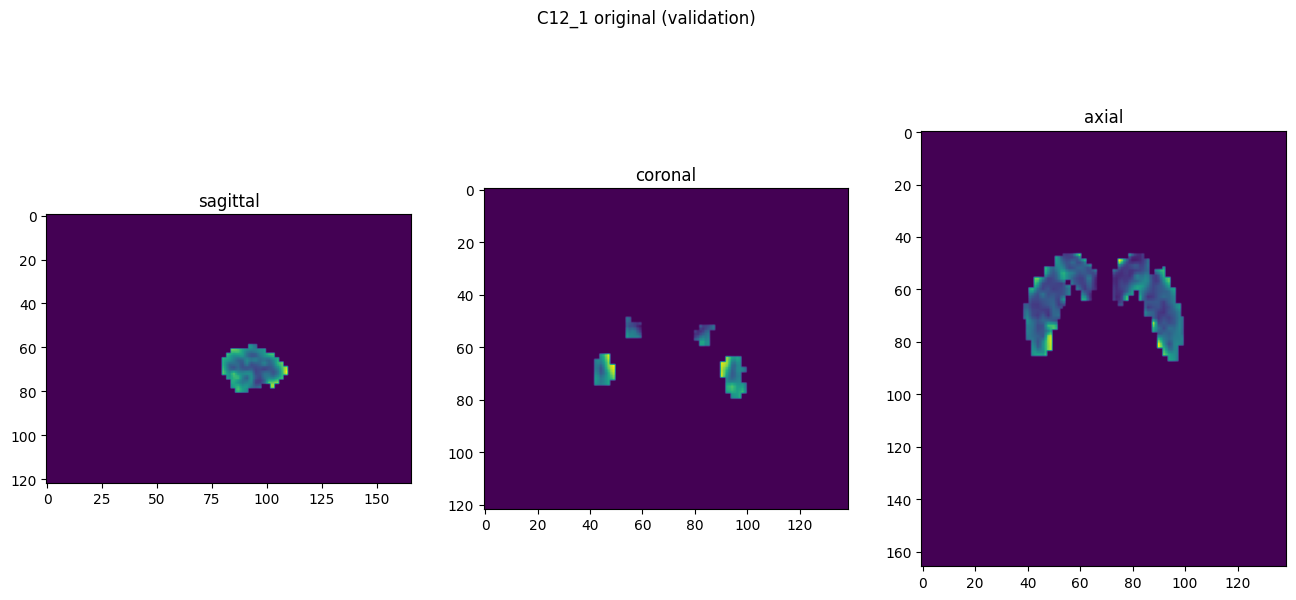

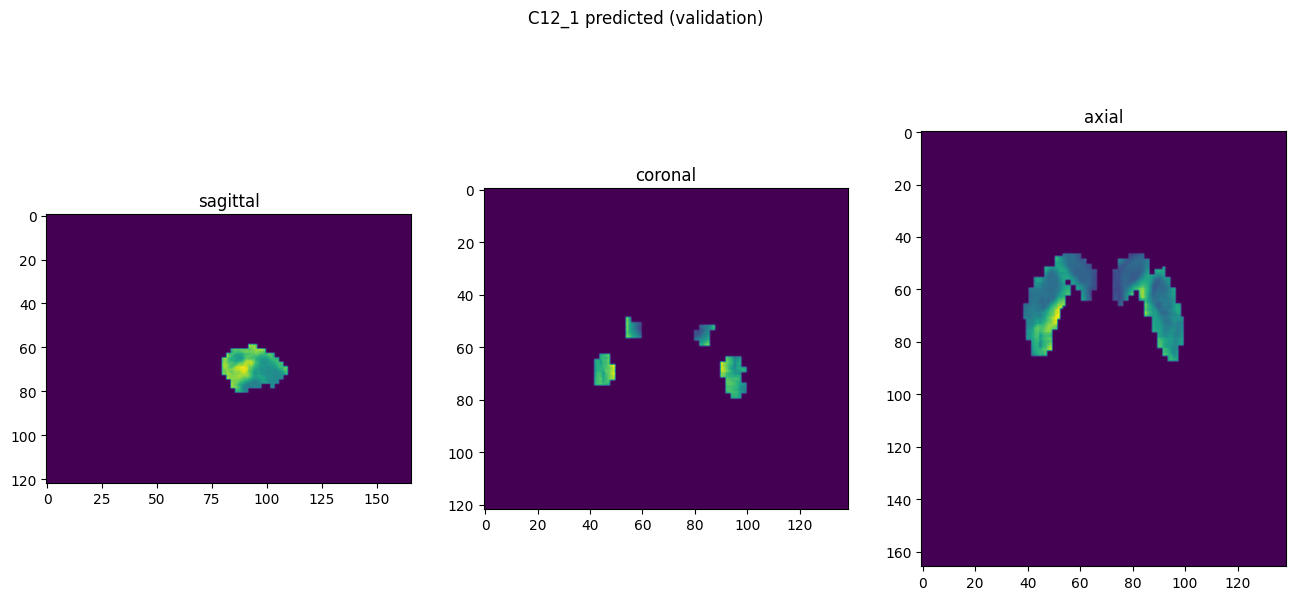

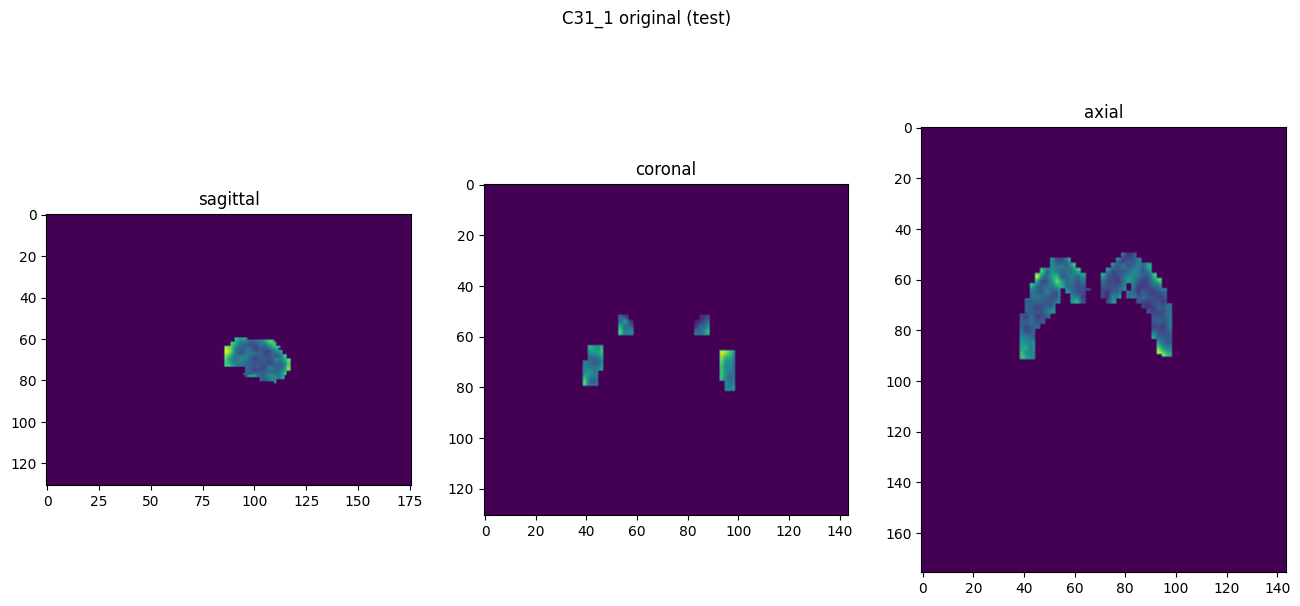

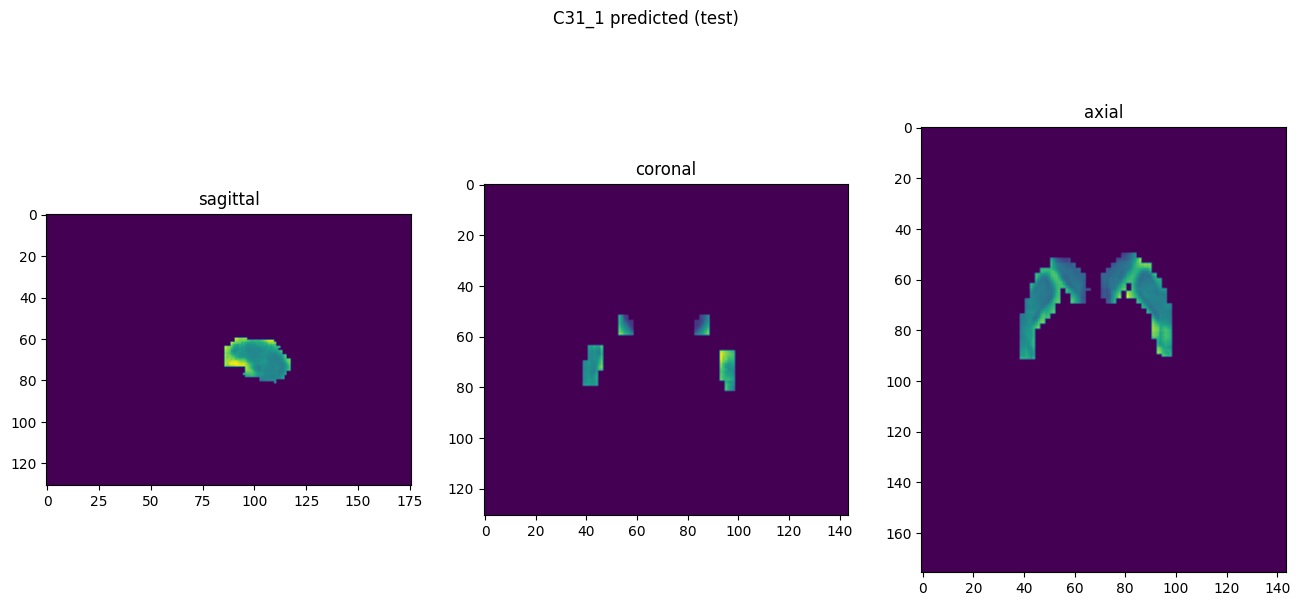

In [10]:
showResults(model, gen, threshold=None, background=False)